### Code to calculate and remove diurnal cycle from the wind lidar data and save the resulting data in a ncdf file
##### author: Claudia Acquistapace
##### what the code does for every variable: 
1) reads the original file for each day for the case study of the 2-3 feb 2020 for each variable <br> 
2) applies the function f_clean_lidar_signal_from_noise to remove noise (method based on threshold+cloud base) <br> 
3) reads the diurnal cycle file for each variable <br> 
4) resamples diurnal cycle on time res of original file <br> 
3) subtracts the diurnal cycle file from each daily file <br> 
5) stores the result of the subtraction and the original variable with noise removed in a ncdf file <br> 
##### goal: obtain in ncdf the arthus variables without noise and with diurnal cycle filtered out 
##### date: 24 Nov 2021

In [31]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime,timedelta
import matplotlib.dates as mdates
import glob
import pandas as pd
import netCDF4 as nc4
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
def f_closest(array,value):
    '''
    # closest function
    #---------------------------------------------------------------------------------
    # date :  16.10.2017
    # author: Claudia Acquistapace
    # goal: return the index of the element of the input array that in closest to the value provided to the function
    '''
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    return idx  



# output paths for plots and data files
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'
path_out ='/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle/'
path_in = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/doppler_lidar/'
Doppler_lidar_file = 'horizontal_wind_direction_msm_eurec4a_campaign.nc'
dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :16,
    'fontSizeY'    :16,
    'cbarAspect'   :10,
    'fontSizeCbar' :16,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :22, 
    'grid'         :True}


# plots settings to be used
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

# variable list
var_list =['Hwind_speed_dict','Hwind_dir_dict']

Hwind_speed_dict = {
     'var_name'  : 'H_speed_no_diurnal_cycle',
     'var_string': 'Horizontal wind speed',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : -10.,
     'var_max'   : 10.,
     'thr_min'   : 0.,
     'thr_max'   : 20.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'H wind speed: 02/02-02/03'}

Hwind_dir_dict = {
     'var_name'  : 'H_dir_no_diurnal_cycle',
     'var_string': 'Horizontal wind direction',
     'var_units' : '$^{\circ}$',
     'var_min'   : -100.,
     'var_max'   : 100.,
     'thr_min'   : 0.,
     'thr_max'   : 360.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'H wind dir: 02/02-02/03'}
dict_list = [Hwind_speed_dict, Hwind_dir_dict]

In [2]:
# read file Doppler lidar 
dataset_lidar = xr.open_dataset(path_in+Doppler_lidar_file)

# converting time from datenum to datetime format (for reference on how to do check https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python)
#time_lidar = lidar_data.Time.values
#python_datetime = []
#for ind, time_val in enumerate(time_lidar):
#    python_datetime.append(datetime.fromordinal(int(time_val)) + timedelta(days=time_val%1) - timedelta(days = 366))

# storing new variable in the xarray dataset
#lidar_data['Time'] = python_datetime

# calculate time resolution
#print('time res :'+str(np.ediff1d(python_datetime)[0]))

In [3]:
# creating a new dataset with proper coordinates, dimensions and variable names
#dims             = ['time','height']
#coords           = {"time":python_datetime, "height":lidar_data['Height'].values}
#H_wind_speed     = xr.DataArray(dims=dims, coords=coords, data=lidar_data['Horizontal wind speed'].values,\
#                     attrs={'long_name':'horizontal wind speed',\
#                            'units':'ms$^{-1}$'})
#H_wind_direction       = xr.DataArray(dims=dims, coords=coords, data=lidar_data['Horizontal wind direction'].values,\
#                     attrs={'long_name':'horizontal wind direction',\
#                            'units':'$^{\circ}$'})
#global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
#                    'CREATED_ON'       :  str(datetime.now()),
#                    'FILL_VALUE'       :  'NaN', 
#                    'AUTHOR_NAME'          : 'Claudia Acquistapace',
#                    'AUTHOR_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
#                    'AUTHOR_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
#                    'AUTHOR_MAIL'          : 'cacquist@meteo.uni-koeln.de',
#                    'DATA_DESCRIPTION' : 'doppler lidar data reformatted in a more convenient data format',
#                    'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
#                    'DATA_GROUP'       : 'Experimental;Profile;Moving',
#                    'DATA_SOURCE'      : 'Doppler lidar data',
#                    'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
#                    'INSTRUMENT_MODEL' : 'arthus raman lidar system',
#                     'COMMENT'         : 'original data postprocessed by Florian Späth' }
#dataset_lidar    = xr.Dataset(data_vars = {'H_wind_speed':H_wind_speed, 
#                                    'H_wind_direction':H_wind_direction},
#                                  coords = coords,
#                                   attrs = global_attributes)

In [4]:
# cutting time from 28.01 to 04.02. and saving the data in a new dataset
time_start = datetime(2020,1,28,0,0,0)
time_end = datetime(2020,2,4,23,59,59)
data_diurnal_cycle = dataset_lidar.sel(time=slice(time_start, time_end))
#data_diurnal_cycle.H_wind_speed.plot(x='time', y='height')
#data_m = np.ma.masked_where(~np.isnan(data_diurnal_cycle.H_wind_speed.values), data_diurnal_cycle.H_wind_speed.values)
#
#time_start = datetime(2020,2,3,0,0,0)
#time_end = datetime(2020,2,4,0,0,0)
##data_sel = dataset_lidar.sel(time=slice(time_start, time_end))
#data_sel.H_wind_speed.plot(x='time', y='height')

In [5]:
# reading noise mask data to filter signal above cloud base
# opening noise mask file to read cloud base
noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
noise_mask = xr.open_dataset(noise_mask_file)

# restricting noise mask data to the data read from Doppler lidar
noise_mask = noise_mask.sel(Time=slice(data_diurnal_cycle['time'].values[0],data_diurnal_cycle['time'].values[-1]))

# interpolating time of the noise mask (BR ratio time res) to the time of the Doppler lidar 
noise_mask_interp = noise_mask.interp(Time=data_diurnal_cycle['time'].values, method='nearest')
cloud_base = noise_mask_interp['cloud_base_height'].values

# find closest height of Doppler lidar data to the cloud base height interpolated on the same time grid
Doppler_lidar_cb = []
for ind_t in range(len(data_diurnal_cycle.time.values)):
    Doppler_lidar_cb.append(data_diurnal_cycle['height'].values[f_closest(data_diurnal_cycle['height'].values, cloud_base[ind_t])])    

# building noise mask for Doppler lidar data
mask = np.ones((len(pd.to_datetime(data_diurnal_cycle['time'].values)),len(data_diurnal_cycle['height'].values)))
for ind in range(len(pd.to_datetime(data_diurnal_cycle['time'].values))):    
    ind_zero = np.where(data_diurnal_cycle['height'].values > Doppler_lidar_cb[ind])
    mask[ind,ind_zero[0]] = 0.


# applying the mask to the product variable
data_diurnal_cycle["nans"] = xr.full_like(data_diurnal_cycle.H_wind_speed, fill_value=np.nan)
data_diurnal_cycle['H_wind_speed'] = xr.where(mask, data_diurnal_cycle['H_wind_speed'], data_diurnal_cycle["nans"])
data_diurnal_cycle['H_wind_direction'] = xr.where(mask, data_diurnal_cycle['H_wind_direction'], data_diurnal_cycle["nans"])


# set to nan the values out of the thresholds for the selected variable (speed or direction)
for i_dict, dict_var in enumerate(dict_list):
    mask = (data_diurnal_cycle[dict_var['var_name']].values > dict_var['thr_min']) & \
    (data_diurnal_cycle[dict_var['var_name']].values < dict_var['thr_max'])
    data_diurnal_cycle["nans"] = xr.full_like(data_diurnal_cycle[dict_var['var_name']], fill_value=np.nan)
    data_diurnal_cycle[dict_var['var_name']] = xr.where(mask, data_diurnal_cycle[dict_var['var_name']], data_diurnal_cycle["nans"])


(0.0, 2500.0)

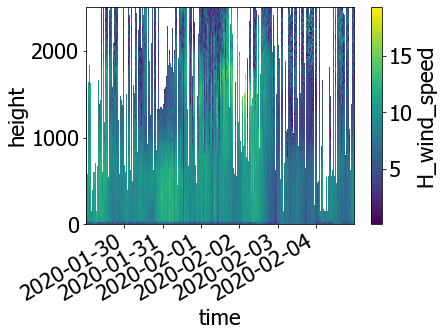

In [6]:
data_diurnal_cycle.H_wind_speed.plot(x='time', y='height')
plt.ylim(0., 2500)

In [7]:

# calculating the mean of the variable over the time interval requested
data_diurnal_cycle = data_diurnal_cycle.resample(time=dict_var['avg_time']+'T').mean()

# re-writing time array as hh:mm for then being able to group
data_diurnal_cycle['time'] = pd.to_datetime(data_diurnal_cycle.time.values).strftime("%H:%M")

# grouping and calculating mean of the profiles
grouped_mean = data_diurnal_cycle.groupby('time').mean()
grouped_std = data_diurnal_cycle.groupby('time').std()
 
# saving diurnal cycle in ncdf file
dims             = ['time','height']
coords           = {"time":pd.to_datetime(grouped_mean['time'].values), "height":grouped_mean['height'].values}
H_speed_diurnal_cycle = xr.DataArray(dims=dims, coords=coords, data=grouped_mean['H_wind_speed'].values,\
                     attrs={'long_name':'diurnal cycle over '+Hwind_speed_dict['avg_time']+'min for '+Hwind_speed_dict['var_string'],\
                            'units':Hwind_speed_dict['var_units']})
H_dir_diurnal_cycle = xr.DataArray(dims=dims, coords=coords, data=grouped_mean['H_wind_direction'].values,\
                     attrs={'long_name':'diurnal cycle over '+Hwind_dir_dict['avg_time']+'min for '+Hwind_dir_dict['var_string'],\
                            'units':Hwind_dir_dict['var_units']})
global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                    'CREATED_ON'       :  str(datetime.now()),
                    'FILL_VALUE'       :  'NaN', 
                    'AUTHOR_NAME'          : 'Claudia Acquistapace',
                    'AUTHOR_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                    'AUTHOR_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                    'AUTHOR_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                    'DATA_DESCRIPTION' : 'diurnal cycle of the variable horizontal wind speed and direction calculated over 15 minutes',
                    'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                    'DATA_GROUP'       : 'Experimental;Profile;Moving',
                    'DATA_SOURCE'      : 'Doppler lidar data',
                    'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                    'INSTRUMENT_MODEL' : 'Doppler lidar system',
                     'COMMENT'         : 'original data postprocessed by Florian Späth' }
dataset_d_cycle    = xr.Dataset(data_vars = {'H_speed':H_speed_diurnal_cycle,
                                     'H_dir':H_dir_diurnal_cycle,},
                                  coords = coords,
                                   attrs = global_attributes)
dataset_d_cycle.to_netcdf(path_out+'H_wind_diurnal_cycle.nc')

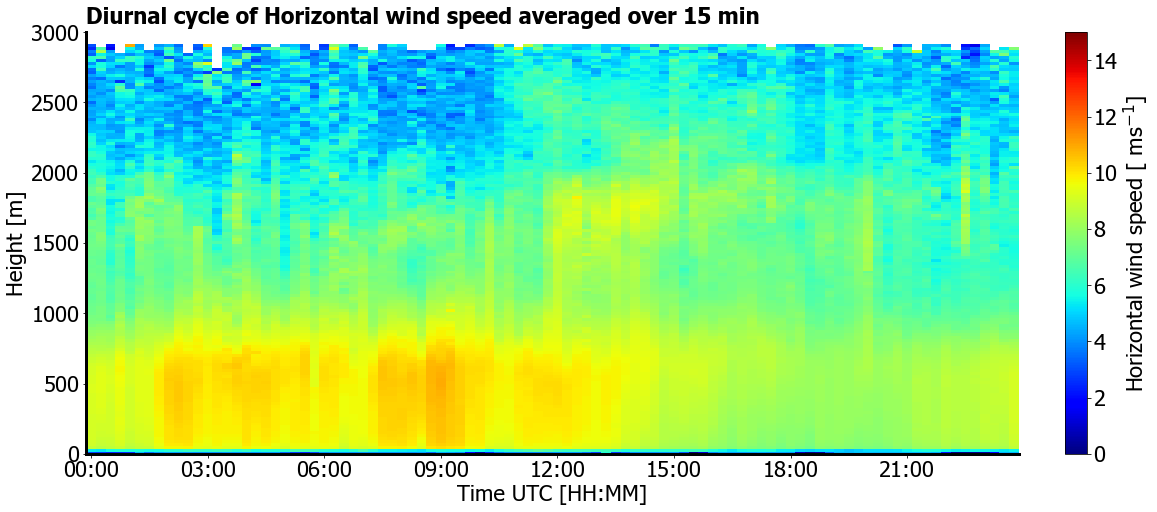

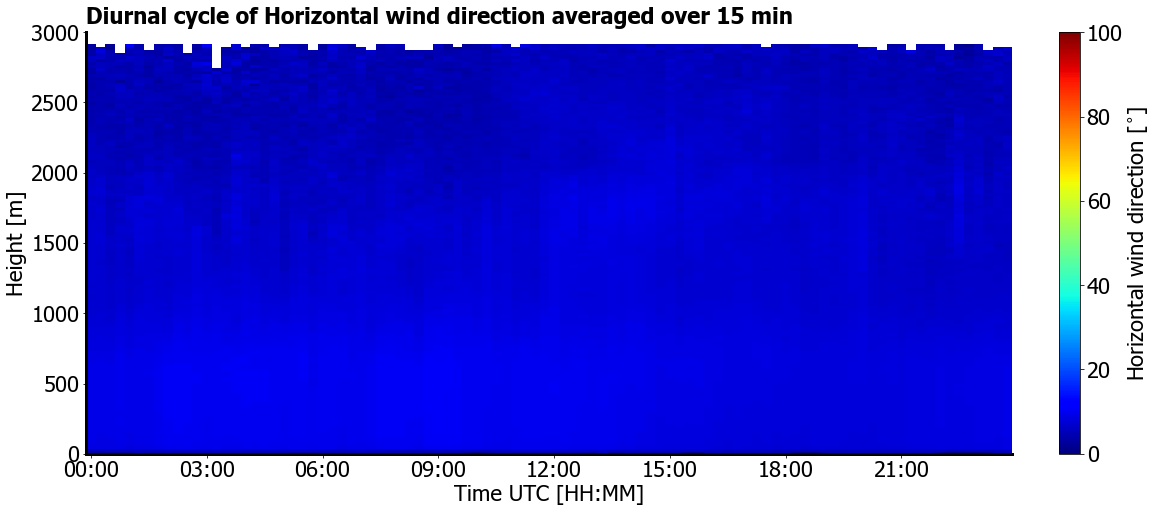

In [8]:
# plotting diurnal cycles of horizontal wind speed and direction
for i_dict, dict_var in enumerate(dict_list):
    
    fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_linewidth(3)
    axs.spines["left"].set_linewidth(3)
    mesh1 = axs.pcolormesh(pd.to_datetime(grouped_mean['time'].values), grouped_mean['height'].values, \
                                 grouped_mean['H_wind_speed'].values.T, vmin=dict_var['var_min'], \
                                 vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)
    cbar = fig2.colorbar(mesh1, ax=axs, label=dict_var['var_string']+' ['+dict_var['var_units']+']', \
                            location='right', aspect=20, use_gridspec=grid)
    axs.set_xlabel('Time UTC [HH:MM]')
    axs.set_ylabel('Height [m]')
    axs.set_ylim(0., 3000.)
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs.text(0, 1.02, 'Diurnal cycle of '+dict_var['var_string']+' averaged over '+dict_var['avg_time']+' min', \
                fontweight='black', transform=axs.transAxes)
    fig2.savefig(path_out_plots+dict_var['var_name']+'_diurnal_cycle.png')

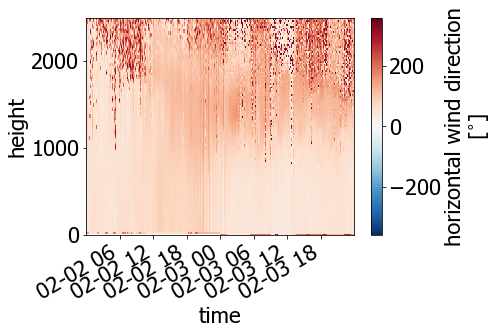

In [9]:
# reading and cleaning from noise the data of the 2-3 Feb 2020
# cutting time from 28.01 to 04.02. and saving the data in a new dataset

def f_extract_cold_patch_data(time_start, time_end, dataset_lidar, noise_mask):

    '''author: claudia Acquistapace
     date: 08/12/2021
     goal: extract data between time start and time end filtered from noise. Filters applied are threshold 
     provided by the manifacturer, removal of rainy time stamps and the removal of the signal above cloud base
     input: 
         - time_start: datetime value of initial time for the dataset
         - time_end: datetima value of final time for the dataset
         - dataset_lidar: xarray dataset containing the data to be selected
         - noise_mask: noise mask provided as input from ncdf
     output: 
         - dataset: xarray dataset of the selected time interval
     '''
    data_cold_patch = dataset_lidar.sel(time=slice(time_start, time_end))
    data_cold_patch.H_wind_direction.plot(x='time', y='height')
    plt.ylim(0., 2500.)

    # reading data containing flags to filter out rainy columns
    flag_file_list = np.sort(glob.glob('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/*_flags_cloud_properties.nc'))
    flag_file_list = flag_file_list[13]
    flag_data = xr.open_mfdataset(flag_file_list) #, dim='time')


    # interpolate flag on time resolution of Doppler lidar data, picking the closest time stamp to lidar time stamps
    flag_data_interp = flag_data.interp(time=data_cold_patch['time'].values, method='nearest')

    # building a mask to filter out Ze rainy columns and substitute them with nans
    # set to nan the values out of the thresholds for the selected variable
    mask = np.zeros((len(data_cold_patch.time.values), len(data_cold_patch.height.values)))
    for ind in range(len(flag_data_interp.time.values)):
        if (flag_data_interp["flag_rain_ground"].values[ind] == 1) | (flag_data_interp["flag_rain"].values[ind] == 1):
            mask[ind,:] = np.repeat(1, len(data_cold_patch.height.values))


    # filtering rain from the fields
    data_cold_patch["nans"] = xr.full_like(data_cold_patch['H_wind_speed'], fill_value=np.nan)
    data_cold_patch['H_wind_speed'] = xr.where(mask == 0, data_cold_patch['H_wind_speed'], data_cold_patch["nans"])
    data_cold_patch['H_wind_direction'] = xr.where(mask == 0, data_cold_patch['H_wind_direction'], data_cold_patch["nans"])
    

    # restricting noise mask data to the data read from Doppler lidar
    noise_mask = noise_mask.sel(Time=slice(data_cold_patch['time'].values[0],data_cold_patch['time'].values[-1]))

    # interpolating time of the noise mask (BR ratio time res) to the time of the Doppler lidar 
    noise_mask_interp = noise_mask.interp(Time=data_cold_patch['time'].values, method='nearest')
    cloud_base = noise_mask_interp['cloud_base_height'].values

    # find closest height of Doppler lidar data to the cloud base height interpolated on the same time grid
    Doppler_lidar_cb = []
    for ind_t in range(len(data_cold_patch.time.values)):
        Doppler_lidar_cb.append(data_cold_patch['height'].values[f_closest(data_cold_patch['height'].values, cloud_base[ind_t])])    

    # building noise mask for Doppler lidar data
    mask = np.ones((len(pd.to_datetime(data_cold_patch['time'].values)),len(data_cold_patch['height'].values)))
    for ind in range(len(pd.to_datetime(data_cold_patch['time'].values))):    
        ind_zero = np.where(data_cold_patch['height'].values > Doppler_lidar_cb[ind])
        mask[ind,ind_zero[0]] = 0.


    # applying the mask to the product variable
    data_cold_patch["nans"] = xr.full_like(data_cold_patch.H_wind_speed, fill_value=np.nan)
    data_cold_patch['H_wind_speed'] = xr.where(mask, data_cold_patch['H_wind_speed'], data_cold_patch["nans"])
    data_cold_patch['H_wind_direction'] = xr.where(mask, data_cold_patch['H_wind_direction'], data_cold_patch["nans"])


    # set to nan the values out of the thresholds for the selected variable (speed or direction)
    for i_dict, dict_var in enumerate(dict_list):
        mask = (data_cold_patch[dict_var['var_name']].values > dict_var['thr_min']) & \
        (data_cold_patch[dict_var['var_name']].values < dict_var['thr_max'])
        data_cold_patch["nans"] = xr.full_like(data_cold_patch[dict_var['var_name']], fill_value=np.nan)
        data_cold_patch[dict_var['var_name']] = xr.where(mask, data_cold_patch[dict_var['var_name']], data_cold_patch["nans"])
    
    return(data_cold_patch)

time_start = datetime(2020,2,2,0,0,0)
time_end = datetime(2020,2,3,23,59,59)
data_cold_patch = f_extract_cold_patch_data(time_start, time_end, dataset_lidar, noise_mask)

# find closest time 
#time_start = datetime(2020,2,3,0,0,0)
#time_end = datetime(2020,2,3,23,59,59)
#dataset_03_feb = f_extract_cold_patch_data(time_start, time_end, dataset_lidar, noise_mask)




In [10]:
data_cold_patch

<xarray.Dataset>
Dimensions:           (height: 400, time: 1782)
Coordinates:
  * time              (time) datetime64[ns] 2020-02-02T00:01:02.282835 ... 20...
  * height            (height) float64 0.0 21.21 42.42 ... 8.442e+03 8.463e+03
Data variables:
    H_wind_speed      (time, height) float64 nan nan nan nan ... nan nan nan nan
    H_wind_direction  (time, height) float64 nan nan nan nan ... nan nan nan nan
    nans              (time, height) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    CREATED_BY:          Claudia Acquistapace
    CREATED_ON:          2022-03-03 18:39:45.379976
    FILL_VALUE:          NaN
    AUTHOR_NAME:         Claudia Acquistapace
    AUTHOR_AFFILIATION:  University of Cologne (UNI), Germany
    AUTHOR_ADDRESS:      Institute for geophysics and meteorology, Pohligstra...
    AUTHOR_MAIL:         cacquist@meteo.uni-koeln.de
    DATA_DESCRIPTION:    doppler lidar data reformatted in a more convenient ...
    DATA_DISCIPLINE:     Atmospheric Physics - Remote Sensing Lidar Profiler
    DATA_GROUP:          Experimental;Profile;Moving
    DATA_SOURCE:         Doppler lidar data
    DATA_PROCESSING:     https://github.com/ClauClouds/SST-impact/
    INSTRUMENT_MODEL:    arthus raman lidar system
    COMMENT:             original data postprocessed by Florian Späth

In [16]:
# calculating variables without the diurnal cycle for both days and saving the vars in ncdf
dates = ['20200202', '20200203']
time_start_arr = [datetime(2020,2,2,0,0,0), datetime(2020,2,3,0,0,0)]
time_end_arr =   [datetime(2020,2,2,23,59,59), datetime(2020,2,3,23,59,59)]
for ind_data in range(len(dates)):

    # calculate new time array for diurnal cycle in datetime format
    time_start = time_start_arr[ind_data]
    time_end = time_end_arr[ind_data]
    print(time_start, time_end)
    new_time = np.arange(time_start, time_end, timedelta(minutes=int(15))).astype(datetime)
    dataset_d_cycle['time'] = new_time
    
    # reading only data for the selected day
    dataset_sel = data_cold_patch.sel(time=slice(time_start,time_end))
        
    # resampling diurnal cycle on arthus time 
    #arthus_data = arthus_data.interp(Time=d_cycle['Time'].values)
    d_cycle = dataset_d_cycle.interp(time=dataset_sel['time'].values, method='nearest')
    
    # subtracting diurnal cycle from arthus variable
    H_speed_no_dc = dataset_sel['H_wind_speed'].values - d_cycle['H_speed'].values
    H_dir_no_dc = dataset_sel['H_wind_direction'].values - d_cycle['H_dir'].values
    
    # save xarray dataset containing the correction terms for the hour
    dims             = ['time','height']
    coords           = {"time":dataset_sel['time'].values, "height":dataset_sel['height'].values}

    H_speed_nodc          = xr.DataArray(dims=dims, coords=coords, data=H_speed_no_dc,
                             attrs={'long_name':dict_var['var_string']+' without diurnal cycle',
                                    'units':''})
    H_speed_no_noise      = xr.DataArray(dims=dims, coords=coords, data=dataset_sel['H_wind_speed'].values,
                             attrs={'long_name':dict_var['var_string']+' with noise removed',
                                    'units':dict_var['var_units']})
    H_dir_nodc          = xr.DataArray(dims=dims, coords=coords, data=H_dir_no_dc,
                             attrs={'long_name':dict_var['var_string']+' without diurnal cycle',
                                    'units':''})
    H_dir_no_noise      = xr.DataArray(dims=dims, coords=coords, data=dataset_sel['H_wind_direction'].values,
                             attrs={'long_name':dict_var['var_string']+' with noise removed',
                                    'units':dict_var['var_units']})

    variables         = {'H_speed_no_diurnal_cycle':H_speed_nodc,
                         'H_dir_no_diurnal_cycle':H_dir_nodc,
                         'H_speed_no_noise':H_speed_no_noise,
                         'H_dir_no_noise':H_dir_no_noise}

    global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : 'Doppler lidar variables with the diurnal cycle removed from the data',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'Doppler lidar data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'Doppler lidar system',
                         'COMMENT'         : 'data only for the 20200202 because no data is available for the 20200203, original data postprocessed by Florian Späth' }
    dataset    = xr.Dataset(data_vars = variables,
                                      coords = coords,
                                       attrs = global_attributes)
    dataset.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'+dates[ind_data]+'_H_wind_speed_dir_no_dc.nc')


 

2020-02-02 00:00:00 2020-02-02 23:59:59
2020-02-03 00:00:00 2020-02-03 23:59:59


In [19]:
path_out_plots

'/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'

<xarray.Dataset>
Dimensions:                   (height: 400, time: 864)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:01:02.28283...
  * height                    (height) float64 0.0 21.21 ... 8.442e+03 8.463e+03
Data variables:
    H_speed_no_diurnal_cycle  (time, height) float64 ...
    H_dir_no_diurnal_cycle    (time, height) float64 ...
    H_speed_no_noise          (time, height) float64 ...
    H_dir_no_noise            (time, height) float64 ...
Attributes:
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2022-03-04 11:14:10.816733
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    PI_AFFILIATION:    University of Cologne (UNI), Germany
    PI_ADDRESS:        Institute for geophysics and meteorology, Pohligstrass...
    PI_MAIL:           cacquist@meteo.uni-koeln.de
    DATA_DESCRIPTION:  Doppler lidar variables with the diurnal cycle removed...
    DATA_DISCIPLINE:   Atmospheric Physics - Remote Sensing

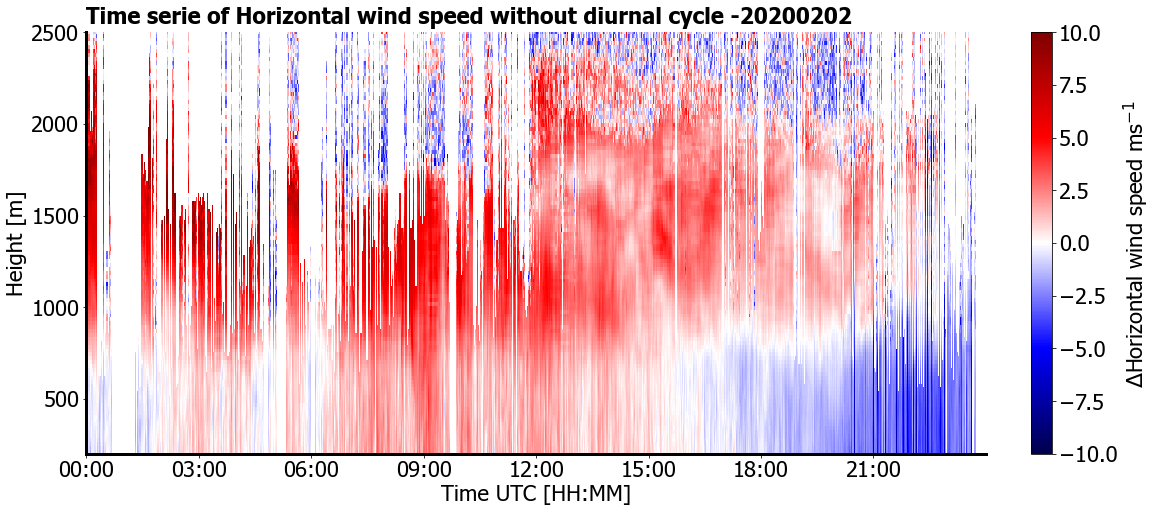

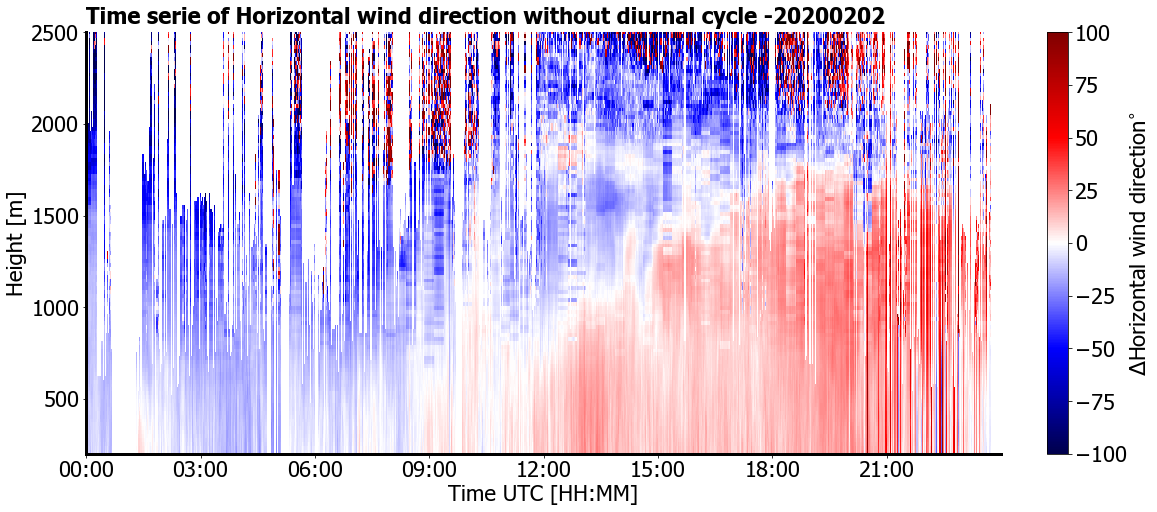

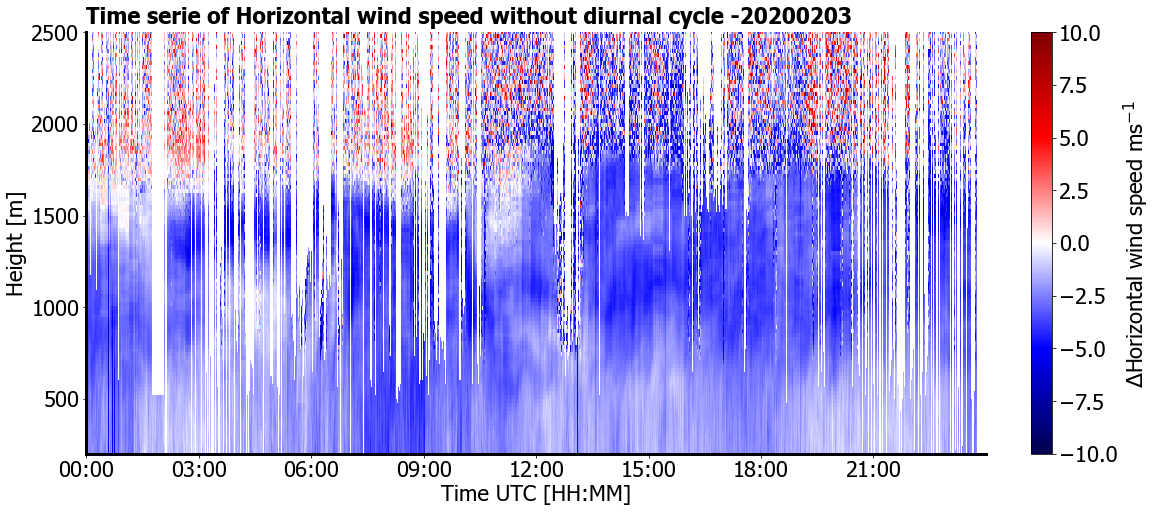

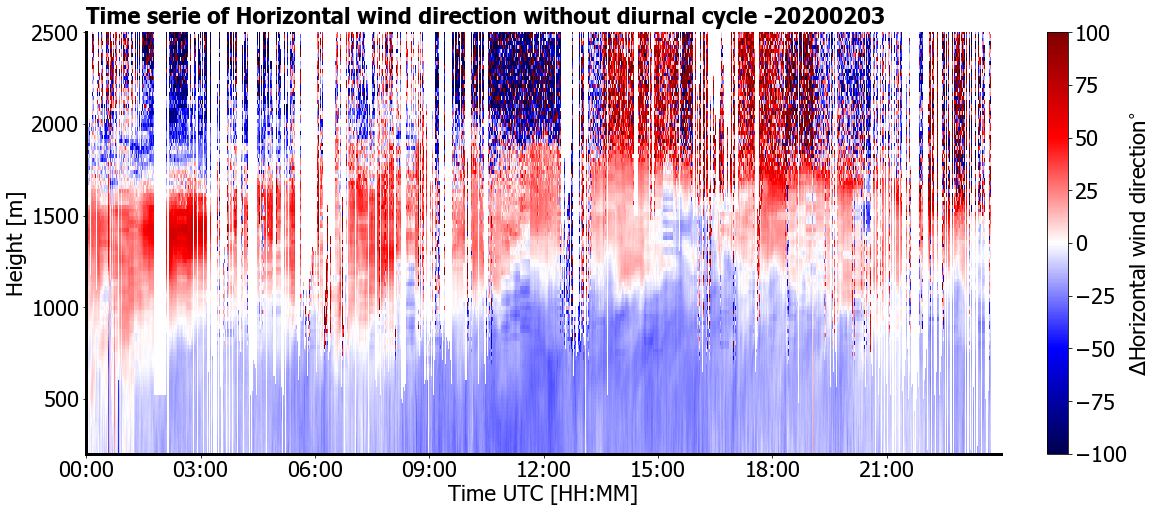

In [33]:
dict_var_list = [Hwind_speed_dict, Hwind_dir_dict] 

for ind_data in range(len(dates)):
    
    data_no_dc = xr.open_dataset('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'+dates[ind_data]+'_H_wind_speed_dir_no_dc.nc')
    print(data_no_dc)
    date = dates[ind_data]
    time_start = time_start_arr[ind_data]
    time_end = time_end_arr[ind_data]
    
    # plots settings to be used
    labelsizeaxes   = 14
    fontSizeTitle   = 16
    fontSizeX       = 16
    fontSizeY       = 16
    cbarAspect      = 10
    fontSizeCbar    = 16
    rcParams['font.sans-serif'] = ['Tahoma']
    matplotlib.rcParams['savefig.dpi'] = 100
    plt.rcParams.update({'font.size':22})
    grid = True


    for ind_var in range(len(dict_var_list)):

        dict_var = dict_var_list[ind_var]


        fig2, axs = plt.subplots(figsize=(16,7), constrained_layout=True, sharex=True)
    

        axs.spines["top"].set_visible(False)
        axs.spines["right"].set_visible(False)
        axs.spines["bottom"].set_linewidth(3)
        axs.spines["left"].set_linewidth(3)
        mesh1 = axs.pcolormesh(data_no_dc['time'].values, data_no_dc['height'].values, \
                                     data_no_dc[dict_var['var_name']].values.T, vmin=dict_var['var_min'], \
                                     vmax=dict_var['var_max'], cmap='seismic', rasterized=True)
        cbar = fig2.colorbar(mesh1, ax=axs, label='$\Delta$'+dict_var['var_string']+dict_var['var_units'], \
                                location='right', aspect=20, use_gridspec=grid)


        axs.set_ylabel('Height [m]')
        axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        axs.text(0, 1.02, 'Time serie of '+dict_var['var_string']+' without diurnal cycle -'+date, \
                    fontweight='black', transform=axs.transAxes)
        axs.set_ylim(200., 2500.)
        axs.set_xlim(time_start, time_end)

        axs.set_xlabel('Time UTC [HH:MM]')
        fig2.savefig(path_out_plots+dict_var['var_name']+'_'+date+'overview_anomaly_dc.png'.format(**dict_var))


In [34]:
# reading tsg file ( data with 1 min resolution)
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)

# building SST binned array
SST_min = np.nanmin(sst_tsg)
SST_max = np.nanmax(sst_tsg)
SST_binned_arr = np.arange(SST_min, SST_max, step=0.025)


# calculate label marks for bins
sst_bin_label = []
for ind in range(len(SST_binned_arr)-1):
    sst_bin_label.append(round((SST_binned_arr[ind]+SST_binned_arr[ind+1])/2,2))
    

In [38]:
# binning variables without diurnal cycle in terms of sst


# reading the ncdf files with the variables and merging them
data_no_dc = xr.open_mfdataset('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/*_H_wind_speed_dir_no_dc.nc')

print(data_no_dc.time.values[0], data_no_dc.time.values[-1])

vars_Doppler_lidar = []

def f_interpolate_SST_and_merge(SST_DS, dataset_obs):
    '''function to interpolate SST values on the time resolution of the observations given as input
    input: 
    SST_DS: xarray dataset containing sst values
    dataset_obs: xarray dataset containing the observations to merge with sst data
    output: 
    data_merged: data returned 
    '''
    
    # interpolating sst data at 1 min resolution to the 10 s res of the wind lidar
    sst_data_interp = SST_DS.interp(time=dataset_obs['time'].values)

    # merging the interpolated dataset and the wind lidar dataset
    data_merged = xr.merge([dataset_obs, sst_data_interp])
    return(data_merged)


    
# interpolating SST data on the arthus data 
Doppler_lidar_SST = f_interpolate_SST_and_merge(SST_DS, data_no_dc)


# calculating mean quantities for each bin
dataset_mean = []
dataset_std = []
dataset_n = []
    
# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = Doppler_lidar_SST.where((Doppler_lidar_SST.SST > SST_binned_arr[ind_bin]) & (Doppler_lidar_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)


    # add variable of the number of elements of the slice
    counts = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = xr.DataArray(dims=['height'], \
                                                coords={'height':DS_sliced['height'].values}, \
                                                data=counts, 
                                               attrs={'long_name':'number of values in each bin SST/height'})        
        

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
    dataset_std.append(DS_sliced.std(dim='time', skipna=True))
    dataset_n.append(DS_sliced['n_elements'])

# concatenating datasets corresponding to SST bins on a new bin dimension
Doppler_SST_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
Doppler_SST_std_concat = xr.concat([dataset_std[i] for i in np.arange(len(dataset_std))], dim='SST_binned')
Doppler_SST_n_concat = xr.concat([dataset_n[i] for i in np.arange(len(dataset_n))], dim='SST_binned')
    
    




2020-02-02T00:01:02.282835000 2020-02-03T23:56:34.000000000


In [39]:

# saving variable of interest in a dictionary with its name
dict_H_wind_nodc = {'H_wind_speed':Doppler_SST_concat['H_speed_no_diurnal_cycle'].values, 
                    'H_wind_spd_std':Doppler_SST_std_concat['H_speed_no_diurnal_cycle'].values,
                    'H_wind_direction':Doppler_SST_concat['H_dir_no_diurnal_cycle'].values, 
                    'H_wind_direction_std':Doppler_SST_std_concat['H_dir_no_diurnal_cycle'].values, 
                   }

dims             = ['sst','height']
coords           = {'sst':SST_binned_arr[0:-1], 'height':Doppler_SST_concat['height'].values}
H_speed          = xr.DataArray(dims=dims, coords=coords, data=Doppler_SST_concat['H_speed_no_diurnal_cycle'].values,
                         attrs={'long_name':'mean H wind speed binned over SST',
                                'units':'ms-1'})
H_speed_std          = xr.DataArray(dims=dims, coords=coords, data=Doppler_SST_std_concat['H_speed_no_diurnal_cycle'].values,
                         attrs={'long_name':'std H wind speed binned over SST',
                                'units':'ms-1'})
H_speed_n          = xr.DataArray(dims=dims, coords=coords, data=Doppler_SST_n_concat.data,
                         attrs={'long_name':'number of H wind speed values in the bin',
                                'units':''})
H_dir          = xr.DataArray(dims=dims, coords=coords, data=Doppler_SST_concat['H_dir_no_diurnal_cycle'].values,
                         attrs={'long_name':'mean H wind direction binned over SST',
                                'units':'degrees'})
H_dir_std          = xr.DataArray(dims=dims, coords=coords, data=Doppler_SST_concat['H_dir_no_diurnal_cycle'].values,
                         attrs={'long_name':'mean H wind direction binned over SST',
                                'units':'degrees'})
H_dir_n          = xr.DataArray(dims=dims, coords=coords, data=Doppler_SST_n_concat.data,
                         attrs={'long_name':'number of H wind direction values in the bin',
                                'units':''})
variables = {'hspd':H_speed,
             'hdir':H_dir, 
             'hspd_n':H_speed_n, 
             'hdir_n':H_dir_n,
            }


global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : 'mean values of H wind speed and direction over SST bins',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'Doppler lidar data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'Doppler lidar system',
                         'COMMENT'         : 'original data postprocessed by Florian Späth' }
dataset_out    = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)
dataset_out.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/H_wind_speed_direction_binned_sst_4.nc')


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


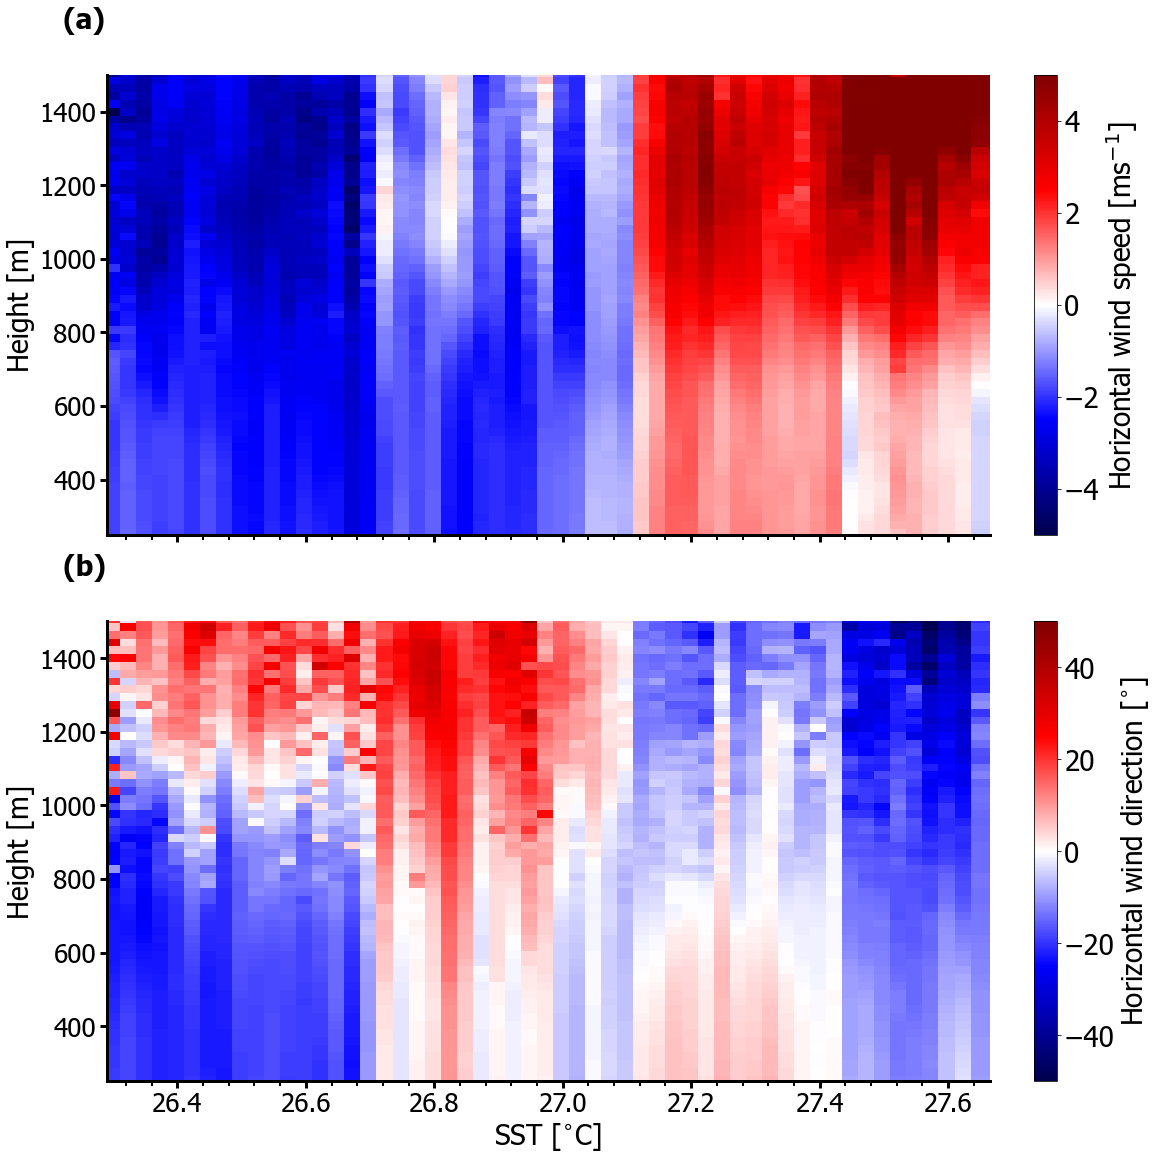

In [42]:
dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :28,
    'fontSizeY'    :28,
    'cbarAspect'   :10,
    'fontSizeCbar' :28,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :28, 
    'grid'         :True}


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(2, 1, figsize=(16,16), sharey=True, sharex=True, constrained_layout=True)

green_diamond = dict(markerfacecolor='b', marker='D')

mesh = axs[0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.hspd.values.T,\
                         cmap='seismic', vmin=-5., vmax=5)
cbar = fig.colorbar(mesh, ax=axs[0])
cbar.set_label(label='Horizontal wind speed [ms$^{-1}$]',  size=fontSizeX)
axs[0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[0].set_ylim(200,1500)


mesh = axs[1].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.hdir.values.T,\
                         cmap='seismic', vmin=-50., vmax=50.)
cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label(label='Horizontal wind direction [$^{\circ}$]',  size=fontSizeX)
axs[1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1].set_ylim(200,1500)
axs[1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)


for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.set_ylim(250.,1500.)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
    #ax.grid(True, which='both', color='grey', linestyle=':')
fig.savefig(path_out_plots+'profile_Hwind_binned_sst.png')

In [43]:
path_out_plots

'/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'